# This notebook is used to explore the mcplate package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pymc
import pymc.Matplot as Matplot
import numpy.polynomial.legendre as legendre
import mcplates
from mcplates import VonMisesFisher
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

In [18]:
# Generate a synthetic data set
lat_hidden = 30.
lon_hidden = 30.
kappa_hidden = 50

vmf = VonMisesFisher('vmf', lon_lat=[lon_hidden,lat_hidden], kappa=kappa_hidden)
data = np.array([vmf.random() for i in range(100)])

model_parameters = []
kappa = pymc.Exponential('kappa', 1.)
lon_lat = VonMisesFisher('lon_lat', lon_lat=(0.,0.), kappa=0.00)
model_parameters.append(kappa)
model_parameters.append(lon_lat)

for sample in data:
    model_parameters.append(VonMisesFisher('direction', lon_lat=lon_lat, kappa=kappa, value=sample, observed=True))

model =pymc.Model(model_parameters)
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 1000, 1)


 [-----------------100%-----------------] 10000 of 10000 complete in 84.7 sec

Plotting lon_lat


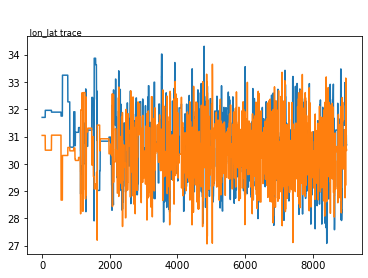

Plotting kappa


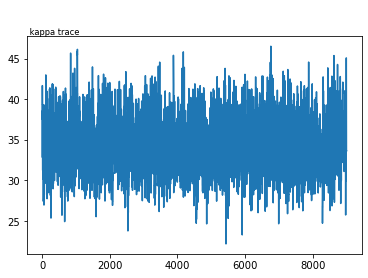

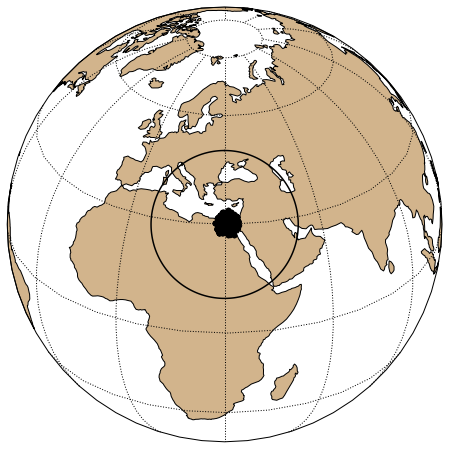

In [19]:
kappa_trace = mcmc.trace('kappa')[:]
lon_trace = np.mod(mcmc.trace('lon_lat')[:,0],360.)
lat_trace = mcmc.trace('lon_lat')[:,1]

Matplot.trace(mcmc.trace('lon_lat'))
plt.show()
Matplot.trace(mcmc.trace('kappa'))
plt.show()

ax = ipmag.make_orthographic_map(lon_hidden, lat_hidden)

ipmag.plot_vgp(ax, lon_trace, lat_trace)
ipmag.plot_pole(ax, lon_hidden, lat_hidden, 140/np.sqrt(kappa_hidden))
# ax.gridlines()
# ax.set_global()
plt.show()

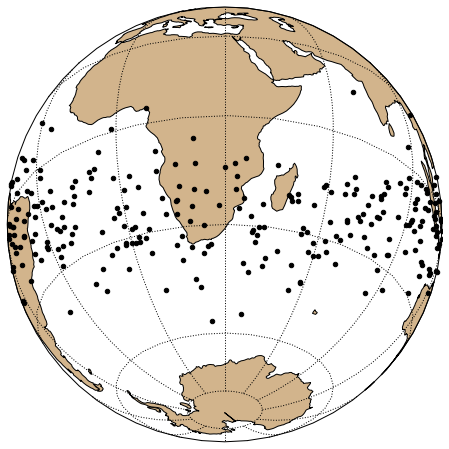

In [4]:
d2r = np.pi/180.
r2d = 180./np.pi

mu_lat = 60.
mu_lon =30.
kappa=-20


sb = mcplates.WatsonGirdle('sb', lon_lat=(mu_lon,mu_lat), kappa=kappa)
samples = np.array([sb.random() for i in range(500)])

phi = samples[:,0]
theta = samples[:,1]

ax = ipmag.make_orthographic_map(mu_lon, mu_lat-90)

ipmag.plot_vgp(ax, phi, theta)

In [17]:
dbname = 'invert_euler_pole.pickle'

# Generate a synthetic data set
ages =[0.,10.,20.,30.,40]
sigma_ages = np.array([2., 2., 2., 2., 2.])
age_taus = 1./sigma_ages*sigma_ages
lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

def pole_position( start, euler_1, rate_1, euler_2, rate_2, switchpoint, time ):
    print( start, euler_1.__dict__, rate_1, euler_2, rate_2, switchpoint, time )
    euler_pole_1 = mcplates.EulerPole( euler_1[0], euler_1[1], rate_1)
    euler_pole_2 = mcplates.EulerPole( euler_2[0], euler_2[1], rate_2)
    start_pole = mcplates.PaleomagneticPole(start[0], start[1], age=time)

    if time <= switchpoint:
        start_pole.rotate( euler_pole_1, euler_pole_1.rate*time)
    else:
        start_pole.rotate( euler_pole_1, euler_pole_1.rate*switchpoint)
        start_pole.rotate( euler_pole_2, euler_pole_2.rate*(time-switchpoint))

    lon_lat = np.array([start_pole.longitude, start_pole.latitude])
    return lon_lat


euler_1 = mcplates.VonMisesFisher('euler_1', lon_lat=(0.,0.), kappa=0.00)
# print(euler_1)
rate_1 = pymc.Exponential('rate_1', 1.) 
euler_2 = mcplates.VonMisesFisher('euler_2', lon_lat=(0.,0.), kappa=0.00)
rate_2 = pymc.Exponential('rate_2', 1.) 

start = mcplates.VonMisesFisher('start', lon_lat=lon_lats[0], kappa=mcplates.kappa_from_two_sigma(10.))
switchpoint = pymc.Uniform('switchpoint', ages[0], ages[-1])

model_vars = [euler_1,rate_1,euler_2,rate_2,start,switchpoint]


for i in range(len(ages)):
    time = pymc.Normal('t'+str(i), mu=ages[i], tau=age_taus[i])
    lon_lat = pymc.Lambda('ll'+str(i), lambda st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : \
                                              pole_position(st, e1, r1, e2, r2, sw, t),\
                                              dtype=np.float, trace=False, plot=False)
    observed_pole = mcplates.VonMisesFisher('p'+str(i), lon_lat, kappa = mcplates.kappa_from_two_sigma(10.), observed=True, value=lon_lats[i])
    model_vars.append(time)
    model_vars.append(lon_lat)
    model_vars.append(observed_pole)

model = pymc.Model( model_vars )


def sample_mcmc( nsample ):
    mcmc = pymc.MCMC(model, db='pickle', dbname=dbname)
    pymc.MAP(model).fit()
    mcmc.sample(nsample)
    mcmc.db.close()
    return mcmc.db

def load_mcmc():
    db = pymc.database.pickle.load(dbname)
    return db


def plot_trace( trace ):
    euler_1_directions = trace('euler_1')[:]
    rates_1 = trace('rate_1')[:]

    euler_2_directions = trace('euler_2')[:]
    rates_2 = trace('rate_2')[:]

    start_directions = trace('start')[:]
    switchpoints = trace('switchpoint')[:]

    interval = max([1,int(len(rates_1)/1000)])

    #ax = plt.axes(projection = ccrs.Orthographic(0.,30.))
    ax = ipmag.make_orthographic_map()
    
    ipmag.plot_vgp( ax, euler_1_directions[:,0], euler_1_directions[:,1])
    ipmag.plot_vgp( ax, euler_2_directions[:,0], euler_2_directions[:,1])

    age_list = np.linspace(ages[0], ages[-1], 100)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    for start, e1, r1, e2, r2, switch \
                 in zip(start_directions[::interval], 
                        euler_1_directions[::interval], rates_1[::interval],
                        euler_2_directions[::interval], rates_2[::interval],
                        switchpoints[::interval]):
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, e2, r2, switch, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.Geodetic(), alpha=0.05)
    for p in lon_lats:
        pole = mcplates.PaleomagneticPole( p[0], p[1], angular_error=10. )
        pole.plot(ax)
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute '__dict__'

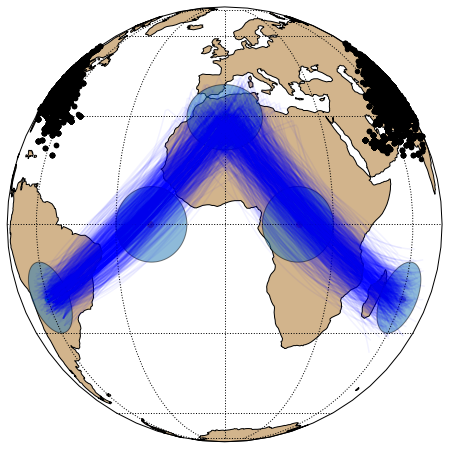

In [6]:

if __name__ == "__main__":
    import os 
    if os.path.isfile(dbname):
        db = load_mcmc()
    else:
        sample_mcmc(10000)
        db = load_mcmc()
    plot_trace(db.trace)

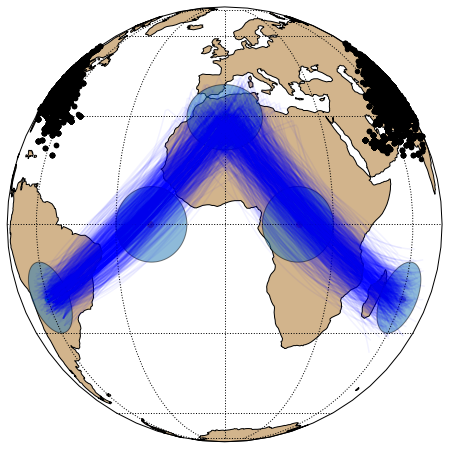

In [7]:
plot_trace(db.trace)

In [8]:
np.linspace(1, 10)

array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612245,  4.48979592,
        4.67346939,  4.85714286,  5.04081633,  5.2244898 ,  5.40816327,
        5.59183673,  5.7755102 ,  5.95918367,  6.14285714,  6.32653061,
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ])